# Initial Data Preparation for Neuroblastoma Analysis

In [1]:
import os
import sys
import feather
import warnings
from tqdm import tqdm

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
from matplotlib_venn import venn2 # For venn diagrams
import matplotlib.backends.backend_pdf # For saving multiple plots in a single pdf

sys.path.append('../')
from src import utils, plots

warnings.filterwarnings('ignore')

# Initialize the timer
startTime = utils.getTime()

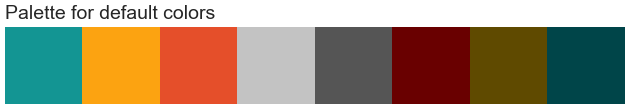

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

In [3]:
notebook_name = "1_preparation"
data_path = "./data/input/"
output_path = f"./data/prepared/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

# Data Provided for the Neuroblastoma Cohort

## Metadata


Details on the contents of the metadata and additional information about the samples:
- **Samples:** the simplified sample names 
    - Only contains patient samples (no standard or supermix)
- **BCCHR ID:** the identifier given from the BC Children's Hospital Research Institute (Might be patient ID)
- **ID:** identifier that originate from patient?? 
    - It has multiple occurrences as well as some has more detail especially in the normal samples
    - (NBLP - NBL Primary)
- **Group:** If the sample is tumor or normal
- **Differentiation:** 
    - Diff, PD, UD, GNBI, n/a
- **MKI:** 
    - High, Int, Low, n/a
- **INPC:** 
    - FH, UH, n/a
    - (Favorable/Unfavorable Histology; depends on age, differentiation, MKI)
    - note, any child over 5 with outright NBL (NOT GNB) is UH -> unsure if applies to Bone Marrow!
- **NMYC:** amplification status of the NMYC gene
    - Not Amp, Amp, n/a
- **Location:**
    - bone marrow, retroperitoneal, paraspinal, mediastinum, brain, liver, bladder, unclear, neck ? LN, soft tissue, lymph node, cervical, thigh, GNBI, neurblastoma undifferentiated
    - note some retro might be paraspinal/mediastinal

---

> **Note:** I had to do manual customization on the metadata to be most useful.

In [4]:
metadata = pd.read_csv(f"{data_path}CustomizedMetadata.csv")
metadata

,Samples,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
0,NBL-macro-1,1,1,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
1,NBL-macro-2,2,2,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
2,NBL-macro-3,3,3,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
3,NBL-macro-4,4,4,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
4,NBL-macro-5,5,5,Tumor,Diff,Low,FH,Not Amp,mediastinum,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
119,NBL-macro-119,119,103,Tumor,PD,Low,FH,NaN,retroperitoneal,NaN,False
120,NBL-macro-120,120,104,Tumor,PD,High,UH,NaN,skin,NaN,False
121,NBL-macro-121,121,105,Tumor,PD,Low,FH,Not Amp,NaN,NaN,False
122,NBL-macro-122,122,106,Normal,NaN,NaN,NaN,NaN,AG,NaN,True


## Protein Data

In [5]:
protein_data = pd.read_excel(f"{data_path}NBL-macro-protein data.xlsx")
print(
    "Number of unique proteins in the dataset:",
    protein_data["PG.ProteinGroups"].nunique()
)

protein_data.index = protein_data["PG.ProteinGroups"].map(utils.select_representative_protein)

print(protein_data.shape)
protein_data.head()

Number of unique proteins in the dataset: 11603
(11603, 168)


,PG.ProteinGroups,PG.Genes,PG.ProteinDescriptions,samplepool,NBL-macro-11,NBL-macro-12,NBL-macro-13,NBL-macro-14,NBL-macro-5,NBL-macro-6,NBL-macro-7,NBL-macro-8,...,samplepool.13,Supermix.11,NBL-macro-16.1,NBL-macro-17.1,NBL-macro-91.1,NBL-macro-95.1,NBL-macro-96.1,NBL-macro-111,NBL-macro-116,NBL-macro-122,samplepool.14,Supermix.12
PG.ProteinGroups,,,,,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,A0A024RBG1,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,956.0441,1420.7034,1860.1465,1978.5979,1213.7629,964.5612,1105.7860,1294.0988,1194.4296,...,518.7156,482.7632,NaN,NaN,264.8033,126.9311,155.9958,NaN,88.6704,199.4570,151.3019,209.8858
A0A075B6I0,A0A075B6I0,IGLV8-61,Immunoglobulin lambda variable 8-61,276.6555,1033.1626,801.9782,343.1009,530.3651,503.8833,250.7079,857.4586,NaN,...,189.2198,NaN,847.1068,NaN,564.2779,NaN,1160.6693,4774.1387,NaN,549.2287,NaN,NaN
P04211,A0A075B6I9;P04211,IGLV7-46;IGLV7-43,Immunoglobulin lambda variable 7-46;Immunoglob...,NaN,1274.6152,NaN,1901.9034,1062.8740,1546.4474,NaN,846.2820,NaN,...,357.0740,NaN,2364.6775,NaN,916.2989,822.1045,1468.7854,12395.8730,NaN,1182.6870,NaN,NaN
A0A075B6J1,A0A075B6J1,IGLV5-37,Immunoglobulin lambda variable 5-37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,495.2946,NaN,NaN,NaN,NaN,NaN
A0A075B6J9,A0A075B6J9,IGLV2-18,Immunoglobulin lambda variable 2-18,NaN,476.2427,528.8539,978.8563,954.8919,491.0235,NaN,1101.2971,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,54.6026,878.2442,37.7063,88.2952,NaN,NaN


## Peptide Level Data

In [6]:
peptide_data = pd.read_csv(
    f"{data_path}20240513_121408_NBL-directDIA_May2024-PeptideReport.tsv",
    sep="\t", engine="pyarrow"
)
print(
    "Number of unique proteins in the dataset:",
    peptide_data["PG.ProteinGroups"].nunique()
)
print(
    "Number of unique peptides in the dataset:",
    peptide_data["PEP.StrippedSequence"].nunique()
)

# Split the data into info and quant only
info_data = peptide_data.iloc[:, :4]
quan_data = peptide_data.iloc[:, 4:]
info_data = info_data[["PG.ProteinGroups", "PEP.StrippedSequence"]]
info_data["PG.ProteinGroups"] = info_data["PG.ProteinGroups"].map(utils.select_representative_protein)

print(peptide_data.shape)
peptide_data.head()

Number of unique proteins in the dataset: 11603
Number of unique peptides in the dataset: 205305
(205305, 169)


,PG.ProteinGroups,PG.Genes,PG.ProteinDescriptions,PEP.StrippedSequence,[1] 20240303_GB_NBL-macro-samplepool_Slot1-17_1_305.htrms.PEP.Quantity,[2] 20240304_GB_NBL-macro-11_Slot1-23_1_313.htrms.PEP.Quantity,[3] 20240304_GB_NBL-macro-12_Slot1-24_1_314.htrms.PEP.Quantity,[4] 20240304_GB_NBL-macro-13_Slot1-25_1_315.htrms.PEP.Quantity,[5] 20240304_GB_NBL-macro-14_Slot1-26_1_316.htrms.PEP.Quantity,[6] 20240304_GB_NBL-macro-5_Slot1-18_1_308.htrms.PEP.Quantity,[7] 20240304_GB_NBL-macro-6_Slot1-19_1_309.htrms.PEP.Quantity,[8] 20240304_GB_NBL-macro-7_Slot1-21_1_311.htrms.PEP.Quantity,...,[154] 20240322_GB_NBL-macro-samplepool-1_Slot1-62_1_497.htrms.PEP.Quantity,[155] 20240322_GB_Supermix-100ng-1_Slot1-61_1_496.htrms.PEP.Quantity,[156] 20240323_GB_NBL-macro-16_Slot1-78_1_515.htrms.PEP.Quantity,[157] 20240323_GB_NBL-macro-17_Slot1-79_1_516.htrms.PEP.Quantity,[158] 20240323_GB_NBL-macro-91_Slot1-80_1_517.htrms.PEP.Quantity,[159] 20240323_GB_NBL-macro-95_Slot1-81_1_518.htrms.PEP.Quantity,[160] 20240323_GB_NBL-macro-96_Slot1-82_1_519.htrms.PEP.Quantity,[161] 20240323_GB_NBL-macro-111_Slot1-75_1_512.htrms.PEP.Quantity,[162] 20240323_GB_NBL-macro-116_Slot1-76_1_513.htrms.PEP.Quantity,[163] 20240323_GB_NBL-macro-122_Slot1-77_1_514.htrms.PEP.Quantity,[164] 20240323_GB_NBL-macro-samplepool-1_Slot1-74_1_511.htrms.PEP.Quantity,[165] 20240323_GB_Supermix-100ng-1_Slot1-73_1_510.htrms.PEP.Quantity
0,A0A024RBG1,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,SEQEDEVLLVSSSR,1445.0571,1338.4825,3118.7183,2938.3445,1621.3723,1617.1815,1854.2969,2169.6836,...,906.3165,603.1483,NaN,NaN,356.1302,212.8125,261.5424,NaN,148.6647,283.0203,130.0792,245.6557
1,A0A024RBG1,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,LLGIFEQNQDR,NaN,NaN,NaN,NaN,NaN,NaN,119.5107,NaN,...,218.3015,448.7576,NaN,NaN,251.4441,NaN,NaN,NaN,NaN,NaN,136.8172,522.7115
2,A0A024RBG1,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,LLGIFEQNQDRK,175.6790,NaN,NaN,246.3403,187.7290,NaN,NaN,NaN,...,82.3486,108.2578,NaN,NaN,59.4372,NaN,NaN,NaN,NaN,NaN,108.2097,NaN
3,A0A024RBG1,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,MKFKPNQTR,623.5397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,612.0175,2067.5813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,460.1821,2727.9946
4,A0A024RBG1,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,TYDREGFK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,464.6029,1164.8453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,517.4937,1289.0729


## Expanding the Metadata with Cleaner Info

In [7]:
tmp = quan_data.columns.to_frame()
tmp["cleaned"] = tmp[0].str.split(" ").str[-1].str.strip(".htrms.PEP.Quantity")
tmp["Date"] = tmp["cleaned"].str.split("_").str[0]
tmp["Samples"] = tmp["cleaned"].str.split("_").str[2]
tmp["Slot"] = tmp["cleaned"].str.split("_").str[3]
tmp.drop([0, 'cleaned'], axis=1, inplace=True)
tmp = tmp.reset_index().rename(columns={"index": "Filename"})
tmp["UniqueNames"] = tmp["Samples"] + "_" + tmp["Slot"]
expanded_metadata = tmp.merge(
    metadata,
    on = "Samples",
    how = "left"
)
print(expanded_metadata.shape)
expanded_metadata.head()

(165, 15)


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
0,[1] 20240303_GB_NBL-macro-samplepool_Slot1-17_...,20240303,NBL-macro-samplepool,Slot1-17,NBL-macro-samplepool_Slot1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[2] 20240304_GB_NBL-macro-11_Slot1-23_1_313.ht...,20240304,NBL-macro-11,Slot1-23,NBL-macro-11_Slot1-23,11.0000,11.0000,Tumor,NaN,NaN,NaN,NaN,brain,NaN,False
2,[3] 20240304_GB_NBL-macro-12_Slot1-24_1_314.ht...,20240304,NBL-macro-12,Slot1-24,NBL-macro-12_Slot1-24,12.0000,12.0000,Tumor,PD,Low,FH,NaN,retroperitoneal,NaN,False
3,[4] 20240304_GB_NBL-macro-13_Slot1-25_1_315.ht...,20240304,NBL-macro-13,Slot1-25,NBL-macro-13_Slot1-25,13.0000,13.0000,Tumor,Diff,Low,FH,NaN,retroperitoneal,NaN,True
4,[5] 20240304_GB_NBL-macro-14_Slot1-26_1_316.ht...,20240304,NBL-macro-14,Slot1-26,NBL-macro-14_Slot1-26,14.0000,14.0000,Tumor,Diff,Low,FH,NaN,retroperitoneal,NaN,True


# Checks on Data

## Mismatched Samples between Metadata and Peptide Data

In [8]:
# Check the metadata["Samples"] and tmp["Sample"] columns
print("Number of unique sampls from metadata:", metadata["Samples"].nunique())
print("Number of unique samples from data:", tmp["Samples"].nunique())
removefromdata = list(set(metadata["Samples"].unique()) - set(expanded_metadata["Samples"].unique()))
print(
    "Samples in metadata but not in the data:", removefromdata
)
removefrommetadata = list(set(tmp["Samples"].unique()) - set(metadata["Samples"].unique()))
print(
    "Samples in data but not in the metadata:", removefrommetadata
)

# Remove the samples that are not in the metadata
expanded_metadata = expanded_metadata[
    ~expanded_metadata["Samples"].isin(removefrommetadata + removefromdata)
].sort_values("ID").reset_index(drop=True)
if expanded_metadata["UniqueNames"].value_counts().max() > 1:
    print("\nThere are duplicates in the column 'UniqueNames'\n")
print(expanded_metadata.shape)
expanded_metadata.head()

Number of unique sampls from metadata: 124
Number of unique samples from data: 128
Samples in metadata but not in the data: ['NBL-macro-123', 'NBL-macro-60']
Samples in data but not in the metadata: ['NBL-macro-samplepool-1-axysealingmat', 'NBL-macro-samplepool-1', 'Supermix-100ng-1', 'NBL-macro-samplepool', 'NBL-macro-samplepool-2', 'Supermix-100ng-2']
(137, 15)


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
0,[122] 20240321_GB_NBL-macro-1_Slot1-51_1_485.h...,20240321,NBL-macro-1,Slot1-51,NBL-macro-1_Slot1-51,1.0000,1.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
1,[110] 20240320_GB_NBL-macro-2_Slot1-35_1_467.h...,20240320,NBL-macro-2,Slot1-35,NBL-macro-2_Slot1-35,2.0000,2.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
2,[123] 20240321_GB_NBL-macro-3_Slot1-52_1_486.h...,20240321,NBL-macro-3,Slot1-52,NBL-macro-3_Slot1-52,3.0000,3.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
3,[124] 20240321_GB_NBL-macro-4_Slot1-53_1_487.h...,20240321,NBL-macro-4,Slot1-53,NBL-macro-4_Slot1-53,4.0000,4.0000,Tumor,NaN,NaN,NaN,NaN,BM,NaN,False
4,[125] 20240321_GB_NBL-macro-5_Slot1-39_1_472.h...,20240321,NBL-macro-5,Slot1-39,NBL-macro-5_Slot1-39,5.0000,5.0000,Tumor,Diff,Low,FH,Not Amp,mediastinum,NaN,False


## Drop Missing Samples and Use Cleaned Names

### Protein Level

In [9]:
protein_data = protein_data[expanded_metadata["Samples"]]
protein_data.columns = expanded_metadata["UniqueNames"]

print(protein_data.shape)
protein_data.head()

(11603, 137)


UniqueNames,NBL-macro-1_Slot1-51,NBL-macro-2_Slot1-35,NBL-macro-3_Slot1-52,NBL-macro-4_Slot1-53,NBL-macro-5_Slot1-39,NBL-macro-5_Slot1-18,NBL-macro-6_Slot1-19,NBL-macro-6_Slot1-40,NBL-macro-7_Slot1-21,NBL-macro-7_Slot1-42,NBL-macro-8_Slot1-20,NBL-macro-8_Slot1-41,...,NBL-macro-111_Slot1-75,NBL-macro-112_Slot1-22,NBL-macro-113_Slot1-23,NBL-macro-114_Slot1-24,NBL-macro-115_Slot1-27,NBL-macro-116_Slot1-76,NBL-macro-117_Slot1-28,NBL-macro-118_Slot1-29,NBL-macro-119_Slot1-30,NBL-macro-120_Slot1-31,NBL-macro-121_Slot1-32,NBL-macro-122_Slot1-77
PG.ProteinGroups,,,,,,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,937.4702,644.4888,1161.1289,1462.8018,964.5612,964.5612,1105.7860,1105.7860,1294.0988,1294.0988,1194.4296,1194.4296,...,NaN,478.0923,607.8417,446.7238,440.9975,88.6704,1101.2657,1280.2126,1409.6562,586.6616,447.9169,199.4570
A0A075B6I0,559.7228,436.7819,661.2460,NaN,503.8833,503.8833,250.7079,250.7079,857.4586,857.4586,NaN,NaN,...,4774.1387,149.0478,384.9225,NaN,143.5704,NaN,400.3751,226.9183,NaN,NaN,163.1270,549.2287
P04211,1653.7424,1197.3619,3315.6892,690.7315,1546.4474,1546.4474,NaN,NaN,846.2820,846.2820,NaN,NaN,...,12395.8730,472.8484,697.6732,542.4109,350.2218,NaN,1131.8433,414.1674,NaN,NaN,NaN,1182.6870
A0A075B6J1,NaN,NaN,NaN,709.0158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6J9,366.2116,NaN,NaN,275.0565,491.0235,491.0235,NaN,NaN,1101.2971,1101.2971,NaN,NaN,...,878.2442,112.3765,169.2677,NaN,NaN,37.7063,221.3154,202.3370,NaN,122.4174,NaN,88.2952


### Peptide Level

In [10]:
# Remove the samples that are not in the metadata
quan_data = quan_data[expanded_metadata["Filename"]]
quan_data.columns = expanded_metadata["UniqueNames"]
print(quan_data.shape)
quan_data.head()

(205305, 137)


UniqueNames,NBL-macro-1_Slot1-51,NBL-macro-2_Slot1-35,NBL-macro-3_Slot1-52,NBL-macro-4_Slot1-53,NBL-macro-5_Slot1-39,NBL-macro-5_Slot1-18,NBL-macro-6_Slot1-19,NBL-macro-6_Slot1-40,NBL-macro-7_Slot1-21,NBL-macro-7_Slot1-42,NBL-macro-8_Slot1-20,NBL-macro-8_Slot1-41,...,NBL-macro-111_Slot1-75,NBL-macro-112_Slot1-22,NBL-macro-113_Slot1-23,NBL-macro-114_Slot1-24,NBL-macro-115_Slot1-27,NBL-macro-116_Slot1-76,NBL-macro-117_Slot1-28,NBL-macro-118_Slot1-29,NBL-macro-119_Slot1-30,NBL-macro-120_Slot1-31,NBL-macro-121_Slot1-32,NBL-macro-122_Slot1-77
0,1730.3057,1080.5488,1946.7467,2700.6494,579.3123,1617.1815,1854.2969,1051.1464,2169.6836,526.4723,2002.5785,1590.5791,...,NaN,801.5687,1415.0425,1030.1877,739.3755,148.6647,1846.3801,2882.6484,2363.4272,1469.5447,874.8881,283.0203
1,288.3805,NaN,NaN,449.4861,NaN,NaN,119.5107,131.5715,NaN,105.9447,NaN,NaN,...,NaN,NaN,NaN,118.2947,NaN,NaN,NaN,199.5442,NaN,119.0281,105.9003,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.4373,NaN,NaN,NaN,78.9474,...,NaN,NaN,67.1211,45.8501,NaN,NaN,NaN,NaN,NaN,66.5386,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check for Duplicate "ID"s

In [11]:
# Checking the duplicate IDs
print("Number of duplicate IDs:", expanded_metadata["ID"].duplicated().sum())
print("Number of duplicate Samples:", expanded_metadata["Samples"].duplicated().sum())
print("Number of duplicate UniqueNames:", expanded_metadata["UniqueNames"].duplicated().sum())

# Return SampleNames per ID only show if nunique > 1
sample_names = expanded_metadata.groupby("ID")["Samples"].unique()
sample_names = sample_names[sample_names.apply(lambda x: len(x) > 1)]
sample_names

Number of duplicate IDs: 32
Number of duplicate Samples: 15
Number of duplicate UniqueNames: 0


ID
9.0000                     [NBL-macro-9, NBL-macro-74]
13.0000                   [NBL-macro-75, NBL-macro-13]
14.0000                   [NBL-macro-76, NBL-macro-14]
23.0000                   [NBL-macro-23, NBL-macro-77]
33.0000                   [NBL-macro-78, NBL-macro-33]
34.0000                  [NBL-macro-34, NBL-macro-124]
38.0000     [NBL-macro-80, NBL-macro-79, NBL-macro-38]
54.0000                   [NBL-macro-81, NBL-macro-54]
61.0000                   [NBL-macro-82, NBL-macro-61]
75.0000                   [NBL-macro-85, NBL-macro-84]
87.0000     [NBL-macro-97, NBL-macro-98, NBL-macro-99]
94.0000                 [NBL-macro-107, NBL-macro-106]
95.0000                 [NBL-macro-108, NBL-macro-109]
100.0000                [NBL-macro-114, NBL-macro-115]
102.0000                [NBL-macro-117, NBL-macro-118]
Name: Samples, dtype: object

In [12]:
# Show the multiple samples per ID
sampleName_occ = expanded_metadata["Samples"].value_counts()
sampleName_occ = sampleName_occ[sampleName_occ > 1]
print("Number of multiple UniqueNames:", sampleName_occ.shape[0])
sampleName_occ

Number of multiple UniqueNames: 15


Samples
NBL-macro-96    2
NBL-macro-11    2
NBL-macro-95    2
NBL-macro-17    2
NBL-macro-16    2
NBL-macro-14    2
NBL-macro-13    2
NBL-macro-12    2
NBL-macro-91    2
NBL-macro-34    2
NBL-macro-9     2
NBL-macro-8     2
NBL-macro-7     2
NBL-macro-6     2
NBL-macro-5     2
Name: count, dtype: int64

### Compare the Identical ID Samples with Visual Inspection

**Note**: This goes over all identical ones and visualize a protein-rank plot and a scatterplot with two samples in each page of a PDF file. (Time consuming ~1min and will be commented out)

In [13]:
# Create a PDF file to save the qc plots for multiple reruns of same samples

pdf = matplotlib.backends.backend_pdf.PdfPages(
    f"{figure_path}SelectReruns.pdf"
)
for cur_sample in sampleName_occ.index:
    data_B = np.log2(quan_data[
        expanded_metadata.loc[expanded_metadata["Samples"] == cur_sample, "UniqueNames"]
    ])

    data_A = data_B.melt(
        var_name="UniqueNames",
        value_name="log2_Intensity"
    ).dropna()

    data_A["Rank"] = data_A.groupby("UniqueNames")["log2_Intensity"].rank(ascending=False)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # A = Peptide Rank
    # Create a rank column in plot_data from each sample
    sns.scatterplot(
        ax=ax[0],
        x="Rank", 
        y="log2_Intensity", 
        hue="UniqueNames", 
        data=data_A, 
        alpha=0.5,
        s=25,
        edgecolor=None,
        linewidth=0,
        rasterized=True
    )


    # B = Intensity Comparison (sample vs sample scatter plot)
    sns.scatterplot(
        ax=ax[1],
        x=data_B.columns[0], 
        y=data_B.columns[1], 
        data=data_B, 
        alpha=0.5,
        s=25,
        edgecolor=None,
        linewidth=0,
        color='grey', 
        rasterized=True
    )

    # Add a diagonal line to the plot
    ax[1].plot(
        [data_B.min().min(), data_B.max().max()],
        [data_B.min().min(), data_B.max().max()],
        color='black',
        linestyle='--'
    )

    for i in range(2):
        ax[i].set_xlabel("log2 Intensity")
        ax[i].set_ylabel("log2 Intensity")
        ax[i].grid(
            "both",
            linestyle="--",
            linewidth=0.75,
            alpha=0.5,
            color="lightgrey"
        )

    # Add a title to the plot
    fig.suptitle(
        f"Sample Comparison: {cur_sample}",
        fontsize=16,
        fontweight='bold'
    )

    sns.despine(
        fig,
        top=True,
        right=True,
        left=True,
        bottom=True
    )

    plt.tight_layout()
    pdf.savefig(
        fig,
        dpi=figure_dpi,
        bbox_inches="tight",
        transparent=transparet_bg
    )
    plt.close()

pdf.close()

The re-runs are done for problematic samples, meaning the latest run is the best quality one. So I will keep those and remove the rest.

In [14]:
expanded_metadata[
    expanded_metadata["Samples"] == "NBL-macro-34"
]

,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
49,[111] 20240320_GB_NBL-macro-34_Slot1-34_1_466....,20240320,NBL-macro-34,Slot1-34,NBL-macro-34_Slot1-34,34.0000,34.0000,Tumor,PD,Int,FH,NaN,soft tissue,NaN,True
51,[28] 20240307_GB_NBL-macro-34_Slot1-16_1_345.h...,20240307,NBL-macro-34,Slot1-16,NBL-macro-34_Slot1-16,34.0000,34.0000,Tumor,PD,Int,FH,NaN,soft tissue,NaN,True


## Keep only the Latest Runs for the Duplicates

In [15]:
# Select the later Slot for the rerun
drop_samples = expanded_metadata[
    expanded_metadata["Samples"].isin(sampleName_occ.index)
].sort_values("Slot").drop_duplicates("Samples", keep="first")

# Remove from the metadata
expanded_metadata = expanded_metadata[
    ~expanded_metadata["UniqueNames"].isin(drop_samples["UniqueNames"])
].reset_index(drop=True)

# Remove from the data
quan_data = quan_data.drop(columns=drop_samples["UniqueNames"])
protein_data = protein_data.drop(columns=drop_samples["UniqueNames"])
print(expanded_metadata.shape)
print(quan_data.shape)
print(protein_data.shape)

(122, 15)
(205305, 122)
(11603, 122)


# Expanded Information for Peptide Info Data

## Protein Fasta (2024_05_20 version)

In [16]:
fastaReference = utils.fasta_to_df(
    f"{data_path}reviewedHumanProteome-2024_05_20.fasta",
    fasta_ID="ID"
).drop(
    columns=["fastaId",  "reviewStatus", "isoformStatus"]
)

print(fastaReference.shape)
fastaReference.head()

(20405, 7)


,entry,entryName,geneName,proteinDescription,sequenceLength,molecularWeight_kDa,sequence
0,A0A024R1R8,TMA7B_HUMAN,TMA7B,Translation machinery-associated protein 7B,64,7.0913,MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAK...
1,A0A024RBG1,NUD4B_HUMAN,NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...,181,20.4339,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...
2,A0A075B6H7,KV37_HUMAN,IGKV3-7,Probable non-functional immunoglobulin kappa v...,116,12.7833,MEAPAQLLFLLLLWLPDTTREIVMTQSPPTLSLSPGERVTLSCRAS...
3,A0A075B6H8,KVD42_HUMAN,IGKV1D-42,Probable non-functional immunoglobulin kappa v...,117,13.0138,MDMRVPAQLLGLLLLWLPGVRFDIQMTQSPSFLSASVGDRVSIICW...
4,A0A075B6H9,LV469_HUMAN,IGLV4-69,Immunoglobulin lambda variable 4-69,119,12.7731,MAWTPLLFLTLLLHCTGSLSQLVLTQSPSASASLGASVKLTCTLSS...


### Check the Fasta Entry Match

Number of unique proteins in the fasta file: 20405
Number of unique proteins in the peptide data: 11603

Number of proteins not in the fasta file: 23
{'Q9NZV5', 'P62341', 'Q9UPP5', 'Q9BVL4', 'P22352', 'Q9NNW7', 'P0DN79', 'P36969', 'Q8WWX9', 'Q8IZQ5', 'iRT-Kit_WR_fusion', 'Q16881', 'O60613', 'Q8IXS6', 'Q9BQE4', 'P0DN76', 'P07203', 'P49908', 'Q9Y6D0', 'Q6ZMK1', 'Q99611', 'Q9C0D9', 'P63302'}


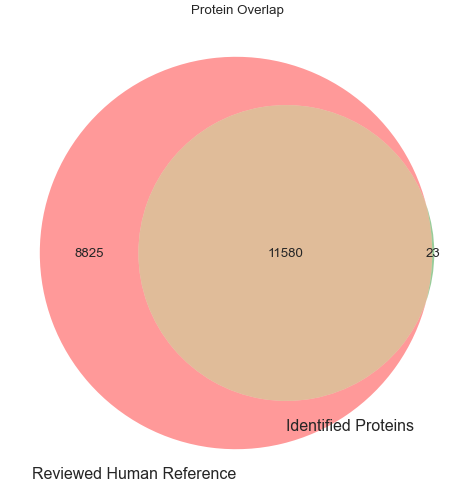

In [17]:
# Check the PG.ProteinGroups column and fasta entry
print("Number of unique proteins in the fasta file:", fastaReference["entry"].nunique())
print("Number of unique proteins in the peptide data:", info_data["PG.ProteinGroups"].nunique())
# Create a venn diagram to show the overlap between the two datasets

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

venn2(
    subsets=(
        set(fastaReference["entry"].tolist()),
        set(info_data["PG.ProteinGroups"].tolist())
    ),
    set_labels=("Reviewed Human Reference", "Identified Proteins"),
    ax=ax
)

plt.title("Protein Overlap")

plt.savefig(
    f"{figure_path}ProteinOverlap.png",
    dpi=figure_dpi,
    bbox_inches="tight",
    transparent=transparet_bg
)

print()
# Find the proteins not in the fasta file
not_in_fasta = set(info_data["PG.ProteinGroups"].unique()) - set(fastaReference["entry"].unique())
print("Number of proteins not in the fasta file:", len(not_in_fasta))
print(not_in_fasta)

### Remove the Non-Matching Proteins

In [18]:
print("Check the proteins that are not in the fasta file and remove them from the data")
# Remove the not in fasta proteins form info_data
print(f"Before: {info_data.shape}")
info_data = info_data[
    ~info_data["PG.ProteinGroups"].isin(not_in_fasta)
]
print(f"After: {info_data.shape}")
quan_data = quan_data.iloc[
    info_data.index
].reset_index(drop=True)
info_data = info_data.reset_index(drop=True)

if info_data.shape[0] == quan_data.shape[0]:
    print("Peptide Data shapes match after modification")

Check the proteins that are not in the fasta file and remove them from the data
Before: (205305, 2)
After: (205034, 2)
Peptide Data shapes match after modification


## Adding the Fasta Data to Peptide Info

In [19]:
info_data.columns = ["Protein", "Peptide"]
info_data = info_data.merge(
    fastaReference,
    left_on="Protein",
    right_on="entry",
    how="left"
)[[
    "Protein", "Peptide", 
    "proteinDescription",
    "entryName", "geneName", 
    "molecularWeight_kDa", 
    "sequence"
]]
info_data["molecularWeight_kDa"] = (info_data["molecularWeight_kDa"] / 1000).round(2)
utils.print_shape(info_data)
info_data.head()

 data has 205,034 rows and 7 columns


,Protein,Peptide,proteinDescription,entryName,geneName,molecularWeight_kDa,sequence
0,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...
1,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...
2,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...
3,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...
4,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...


## Add Peptide Start and End Positions on the Protein

In [20]:
# Find the start and end position of the peptides in the protein sequence
info_data["startpos"] = info_data.apply(
    lambda x: x["sequence"].find(x["Peptide"]),
    axis=1
)
info_data["endpos"] = info_data["startpos"] + info_data["Peptide"].str.len()

# Non-matching peptides
nonMatchidx = info_data[info_data["startpos"] < 1].index
print("Number of non-matching peptides:", len(nonMatchidx))
print("Droping non-matching peptides...")
# Remove the non-matching peptides
info_data = info_data.drop(index=nonMatchidx).reset_index(drop=True)
quan_data = quan_data.drop(index=nonMatchidx).reset_index(drop=True)

utils.print_shape(info_data, "Info")
utils.print_shape(quan_data, "Quant")

info_data["seqLength"] = info_data["sequence"].str.len()

print("Is same index?", info_data.shape[0] == quan_data.shape[0])

# Unique proteins
unique_proteins = list(info_data["Protein"].unique())

# Sort the info data by Protein, Peptide start, and end positions
info_data = info_data.sort_values(["Protein", "startpos", "endpos"])
cur_idx = info_data.index
info_data = info_data.reset_index(drop=True)
quan_data = quan_data.iloc[cur_idx].reset_index(drop=True)
info_data.set_index("Protein", inplace=True)
info_data.head()

Number of non-matching peptides: 1166
Droping non-matching peptides...
Info data has 203,868 rows and 9 columns
Quant data has 203,868 rows and 122 columns
Is same index? True


,Peptide,proteinDescription,entryName,geneName,molecularWeight_kDa,sequence,startpos,endpos,seqLength
Protein,,,,,,,,,
A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,1,10,181
A0A024RBG1,FKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,3,10,181
A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,10,18,181
A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,27,41,181
A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,79,90,181


## Handling Missed Cleaved Peptides with max 3 AAs Difference

### Find the Overlapping Peptides with Max 3 AAs Difference

> NOTE: This will be commented out for the time being since I don't know how much it will be useful for the downstream analysis.

In [21]:
# # Create a dictionary to store the overlapping peptides
# protein_Overlaps = {}
# # Go over each protein and find the unique peptides
# for protein in tqdm(unique_proteins, desc="Finding Overlaps"):
#     # Get the subset of the protein
#     subset = info_data.loc[protein, :]
#     # If subset is not a DataFrame
#     if not isinstance(subset, pd.DataFrame):
#         protein_Overlaps[protein] = {}
#         continue
#     # If the protein has overlap
#     startpos_arr = subset["startpos"].values
#     endpos_arr = subset["endpos"].values
#     # Create a dictionary to store the overlapping peptides
#     groupedMissCleaves = utils.group_miss_cleaved_peptides(startpos_arr, endpos_arr, max_diff=3)
#     # If there are no overlapping peptides
#     if len(groupedMissCleaves) == 0:
#         continue
#     # Store the overlapping peptides
#     protein_Overlaps[protein] = groupedMissCleaves


### Group the Overlapping Peptides with Longer Representative and Sum the Intensities

> NOTE: This will be commented out for the time being since I don't know how much it will be useful for the downstream analysis.

In [22]:
# # Initialize dictionaries to collect data
# new_quan_data_dict = {}
# new_info_data_dict = {}

# # Set the index of the new dataframes
# quan_data.index = info_data.index
# quanCols = quan_data.columns
# infoCols = info_data.columns

# # Go over each protein
# for protein in tqdm(unique_proteins, desc="Merging Overlaps"):
#     # Get the overlapping peptides
#     groupedMissCleaves = protein_Overlaps[protein]
#     subInfo = info_data.loc[protein, :].reset_index(drop=True)
#     subQuant = quan_data.loc[protein, :].reset_index(drop=True)

#     if len(groupedMissCleaves) > 0:
#         # Get the subset for info data
#         subInfo = subInfo.iloc[list(groupedMissCleaves.keys())] 
#         # Setup a list to store the rows
#         row_list = []
#         # Go over the overlapping peptides
#         for k, v in groupedMissCleaves.items():
#             if len(v) > 1:  # If there are overlapping peptides
#                 row_list.append(subQuant.iloc[v].sum().to_frame().T)
#             else:  # If there are no overlapping peptides
#                 row_list.append(subQuant.iloc[k].to_frame().T)
#         # Concatenate the rows
#         subQuant = pd.concat(row_list, axis=0, ignore_index=True).replace(0, np.nan)
#     else: # Convert to DataFrame
#         subQuant = subQuant.to_frame().T
#         subQuant.columns = quanCols
#         subInfo = subInfo.to_frame().T
#         subInfo.columns = infoCols

#     # Set Protein Column for both
#     subQuant["Protein"] = protein
#     subInfo["Protein"] = protein

#     # Collect the data
#     new_quan_data_dict[protein] = subQuant.to_dict(orient='index')
#     new_info_data_dict[protein] = subInfo.to_dict(orient='index')

# # Convert dictionaries to DataFrames
# new_quan_data = pd.DataFrame.from_dict(
#     {(i, j): new_quan_data_dict[i][j] for i in new_quan_data_dict.keys() for j in new_quan_data_dict[i].keys()}, 
#     orient='index'
# )

# new_info_data = pd.DataFrame.from_dict(
#     {(i, j): new_info_data_dict[i][j] for i in new_info_data_dict.keys() for j in new_info_data_dict[i].keys()}, 
#     orient='index'
# )
# new_quan_data["Peptide"] = new_info_data["Peptide"].to_list()

# new_quan_data = new_quan_data.set_index(["Protein", "Peptide"])
# new_info_data = new_info_data.set_index(["Protein", "Peptide"])

## Add Protein Coverage and Peptide Trace Info for Plotting

In [23]:
# If new_info_data and new_quan_data doesn't exist create them
if not "new_info_data" in locals():
    new_info_data = info_data.copy()
    new_quan_data = quan_data.copy()

# Set only protein index
new_info_data = new_info_data.reset_index().set_index("Protein")
# Create a dictionary to store the protein coverage
protein_coverage = {}
protein_peptide_traces = {}
# Go over each protein and find the unique peptides
for protein in tqdm(unique_proteins, desc="Finding Protein Coverage"):
    # assign traces to non-overlapping peptides
    gap = 0
    trace_ends, traces = [-gap], []
    subset = new_info_data.loc[protein]
    trace_map = {}
    # If subset is not a DataFrame
    if not isinstance(subset, pd.DataFrame):
        # If only single peptide the peptide length is the coverage
        seqLen = subset["seqLength"]
        coverage_perc = (len(subset["Peptide"]) / seqLen) * 100
        trace_map = {subset["Peptide"] : 0}
    else:
        subset = subset.sort_values(["startpos", "endpos"], ascending=True).reset_index(drop=True)
        seqLen = subset["seqLength"].values[0]
        coverage = np.zeros(seqLen)
        for i in subset.itertuples():
            coverage[i.startpos:i.endpos] = 1
            traced = False
            for t in range(len(trace_ends)):
                if i.startpos >= trace_ends[t] + gap:
                    traces.append(t)
                    trace_ends[t] = i.endpos
                    traced = True
                    break
            if not traced:
                traces.append(len(trace_ends))
                trace_ends.append(i.endpos)
        # Calculate the coverage percentage
        coverage_perc = (coverage.sum() / seqLen) * 100
        # Create a trace map
        trace_map = dict(zip(subset["Peptide"], traces))
    
    protein_coverage[protein] = coverage_perc
    # Create protein-peptide traces dictionary
    protein_peptide_traces[protein] = trace_map

# Create a dataframe from the protein_peptide_traces dictionary
tmp = utils.dict_to_protein_peptide_df(protein_peptide_traces)
tmp["Cov%"] = tmp["Protein"].map(protein_coverage)

idx = new_info_data.reset_index().set_index(["Protein", "Peptide"]).index
new_info_data["trace"] = idx.map(tmp.set_index(["Protein", "Peptide"])["Trace"])
new_info_data["Cov%"] = new_info_data.index.map(protein_coverage)

utils.print_shape(new_info_data)
new_info_data.head()

Finding Protein Coverage: 100%|██████████| 11560/11560 [00:11<00:00, 1025.04it/s]


 data has 203,868 rows and 11 columns


,Peptide,proteinDescription,entryName,geneName,molecularWeight_kDa,sequence,startpos,endpos,seqLength,trace,Cov%
Protein,,,,,,,,,,,
A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,1,10,181,0,23.7569
A0A024RBG1,FKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,3,10,181,1,23.7569
A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,10,18,181,0,23.7569
A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,27,41,181,0,23.7569
A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUD4B_HUMAN,NUDT4B,0.0200,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,79,90,181,0,23.7569


# Visualize the Protein Coverage

**Protein Coverage:** The protein coverage is calculated by the number of amino acids in the protein that are covered by the identified peptides. The coverage is calculated as the number of amino acids covered divided by the total number of amino acids in the protein.

## Protein Length vs Peptide Count Scatterplot

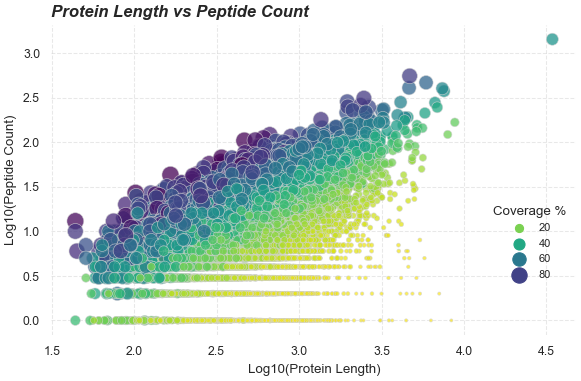

In [24]:
# Figure for protein length, peptide number, and coverage (scatter plot)
plot_data = new_info_data.groupby("Protein").agg(
    seqLength=("seqLength", "first"),
    PeptideCount=("Peptide", "count"),
    CovPerc=("Cov%", "first")
).reset_index()
plot_data["seqLength"] = np.log10(plot_data["seqLength"])
plot_data["PeptideCount"] = np.log10(plot_data["PeptideCount"])

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.scatterplot(
    ax=ax,
    data=plot_data,
    x="seqLength", 
    y="PeptideCount", 
    hue="CovPerc", 
    size="CovPerc",
    palette="viridis_r",
    sizes=(5, 150),
    alpha=0.75,
    edgecolor="lightgrey",
    linewidth=0.5,
    legend="brief",
)
ax.set_xlabel("Log10(Protein Length)")
ax.set_ylabel("Log10(Peptide Count)")
ax.set_title("Protein Length vs Peptide Count", fontsize=12, weight="bold", style="italic", loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(title="Coverage %", loc="upper right", bbox_to_anchor=(1., .45), fontsize=8, frameon=False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig(
    f"{figure_path}ProteinLength_PeptideCount_Coverage.png",
    dpi=figure_dpi,
    bbox_inches="tight",
    transparent=transparet_bg
)

## Protein Coverage Distribution

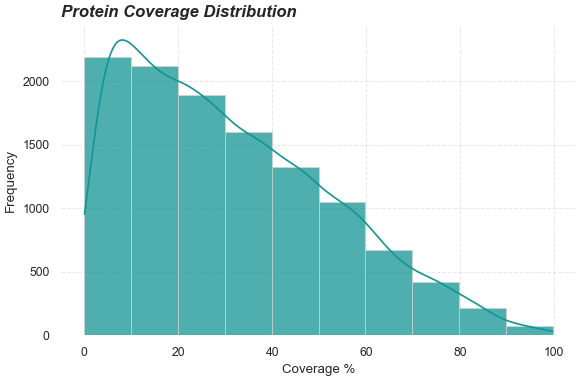

In [25]:
# Histogram of protein coverage
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(
    ax=ax,
    data=plot_data,
    x="CovPerc",
    bins=10,
    kde=True,
    color=def_colors[0],
    alpha=0.75,
    edgecolor="lightgrey",
    linewidth=0.5,
)
ax.set_xlabel("Coverage %")
ax.set_ylabel("Frequency")
ax.set_title("Protein Coverage Distribution", fontsize=12, weight="bold", style="italic", loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig(
    f"{figure_path}ProteinCoverageDistribution.png",
    dpi=figure_dpi,
    bbox_inches="tight",
    transparent=transparet_bg
)

# Finalize with Saving the Data

## Map the CAP Proteins to Gene Symbols and to Info

The cancer-associated proteins (~350) extracted from the literature and uniprot as gene symbols and will be find out how many of them are in the dataset then map them to the info_data for further reference.

In [26]:
cap_genes = set(pd.read_csv(f"{data_path}PediatricCancerAssociatedGenes-CAPS list.txt", sep='\t').iloc[:, 0].values)
genes_in_data = set(new_info_data['geneName']).intersection()
print(f"Number of CAP genes from lit/uniprot: {len(cap_genes)}")
print(f"Number of Genes in the data: {len(genes_in_data)}")
print(f"Number of CAP genes in the data: {len(genes_in_data.intersection(cap_genes))}")
print(f"Missing CAP genes in the data: {len(cap_genes - genes_in_data)}")
for i in cap_genes - genes_in_data:
    print(f" - {i}")

# Add the CAP gene information to the info_data
new_info_data['isCAP'] = new_info_data['geneName'].isin(list(genes_in_data.intersection(cap_genes)))
drop_cols = ['molecularWeight_kDa', 'entryName', 'sequence']
new_info_data.drop(columns=drop_cols, inplace=True)

Number of CAP genes from lit/uniprot: 350
Number of Genes in the data: 11538
Number of CAP genes in the data: 266
Missing CAP genes in the data: 84
 - CCNE1
 - RAD51B
 - INI
 - KDR
 - GLI1
 - CXCL1
 - PLAG1
 - RBBP8
 - FANCE
 - TSPAN4
 - CCR5
 - LMO2
 - MKL1
 - NOTCH4
 - HOXB13
 - RAD54L
 - MYBL1
 - CCND2
 - PDGFB
 - BCL6
 - FANCF
 - PAX3
 - FLT3
 - MPL
 - ROS1
 - CSF3R
 - CEBPA
 - MDM4
 - FGF4
 - BARD1
 - TMB
 - E2F1
 - NUTM1
 - FGF3
 - WHSC1
 - FOSB
 - MUC16
 - WT1
 - TSLP
 - AR
 - CLDN4
 - RAD52
 - XRCC2
 - FAAP24
 - MRE11A
 - MYC
 - CDKN2B
 - GRM3
 - CTLA4
 - FAN1
 - HEK27
 - MDM2
 - ADORA2A
 - JAK3
 - NR4A3
 - FAM175A
 - PTCH1
 - H3F3A
 - NUTM2B
 - FBXW7
 - PTCH1PTEN
 - PIK3CA 
 - MEF2B
 - HGF
 - FANCC
 - CRLF2
 - MN1
 - SETBP1
 - FGFR4
 - MYOD1
 - HIST1H3B
 - TP63
 - IL7R
 - MYB
 - USP6
 - TERT
 - SLX1A
 - PGR
 - ERBB4
 - FGFR3
 - TNFRSF8
 - GLIS2
 - PLAB2
 - DLL3


## Prepared Tables

In [27]:
if new_info_data.shape[0] == new_quan_data.shape[0]:
    pd.concat(
        [new_info_data.reset_index(), new_quan_data.reset_index(drop=True)],
        axis=1
    ).to_feather(
        f"{output_path}NBL_directDIA_May2024.feather"
    )

protein_data.to_feather(
    f"{output_path}NBL_directDIA_May2024_protein.feather"
)

expanded_metadata.to_csv(
    f"{output_path}NBL_directDIA_May2024_metadata.csv",
    index=False
)

## UniProt Annotation Table

In [28]:
# Process the uniprot file
uniprot_df = utils.preprocess_uniprot(
    "./data/input/uniprotkb_taxonomy_id_2759_AND_model_or_2024_05_25.txt"
)
# Subset the uniprot data to the proteins in the info_subset
uniprot_df = uniprot_df[uniprot_df["protein_id"].isin(new_info_data.reset_index()["Protein"].unique())]

print(f"Saving the uniprot annotation data to a feather file.")
utils.print_shape(uniprot_df, "Uniprot Data")
feather.write_dataframe(uniprot_df, f"{output_path}Uniprot_Annotation.feather")
uniprot_df.head()

Saving the uniprot annotation data to a feather file.
Uniprot Data data has 498,473 rows and 6 columns


,protein_id,feature,isoform_id,start,end,note
941,A0AV96,CHAIN,,1.0000,593.0000,RNA-binding protein 47
942,A0AV96,DOMAIN,,71.0000,149.0000,RRM 1
943,A0AV96,DOMAIN,,151.0000,233.0000,RRM 2
944,A0AV96,DOMAIN,,246.0000,318.0000,RRM 3
945,A0AV96,REGION,,1.0000,25.0000,Disordered


# Conclusion

WIP

In [29]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - startTime))

Notebook Execution Time: 00h:01m:46s
